# Customer Engagement

We'll go over on how to build a random forest predictive model on customer marketing engagement.  With better predictions on how customers will engage to certain marketing campaigns, a marketer can tailor strategies for different audiences [1].  The offical marketing term we are looking for here is the "likelihood of engagement."  One concerte example of this is isolating what type of customers will respond to which type of ads (e.g. females ages 20-39 responding to Facebook Ads v. Google Ads - totally made that up).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

In [2]:
#load data
custd = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [3]:
custd.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [4]:
#Encoding output variable
custd['Engaged'] = custd['Response'].apply(lambda x: 1 if x == 'Yes' else 0)

The apply function turns Yes responses into 1's and everything else into 0's.  Yes meaning the customer was engaged, while no meaning not engaged.  So the average engagement rate is:

In [5]:
custd['Engaged'].mean()

0.14320122618786948

In [6]:
#Checking out features
custd.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Engaged
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,0.143201
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.350297
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,0.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,0.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,0.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,1.000000


In [7]:
#Feature Engineering
continuous_features = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
    'Months Since Last Claim', 'Months Since Policy Inception',
    'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']

In [8]:
columns_to_encode = ['Sales Channel', 'Vehicle Size', 'Vehicle Class', 'Policy', 'Policy Type', 
    'EmploymentStatus', 'Marital Status', 'Education', 'Coverage']

categorical_features = []
for col in columns_to_encode:
    encoded_df = pd.get_dummies(custd[col])
    encoded_df.columns = [col.replace(' ', '.') + '.' + x for x in encoded_df.columns]
    
    categorical_features += list(encoded_df.columns)
    
    custd = pd.concat([custd, encoded_df], axis=1)
    
custd['Is.Female'] = custd['Gender'].apply(lambda x: 1 if x == 'F' else 0)

categorical_features.append('Is.Female')

In [9]:
all_features = continuous_features + categorical_features
response = 'Engaged'

In [10]:
sample_custd = custd[all_features + [response]]
sample_custd.columns = [x.replace(' ', '.') for x in sample_custd.columns]
all_features = [x.replace(' ', '.') for x in all_features]

In [11]:
sample_custd.head()

,Customer.Lifetime.Value,Income,Monthly.Premium.Auto,Months.Since.Last.Claim,Months.Since.Policy.Inception,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Sales.Channel.Agent,Sales.Channel.Branch,...,Education.Bachelor,Education.College,Education.Doctor,Education.High.School.or.Below,Education.Master,Coverage.Basic,Coverage.Extended,Coverage.Premium,Is.Female,Engaged
0,2763.519279,56274,69,32,5,0,1,384.811147,1,0,...,1,0,0,0,0,1,0,0,1,0
1,6979.535903,0,94,13,42,0,8,1131.464935,1,0,...,1,0,0,0,0,0,1,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,1,0,...,1,0,0,0,0,0,0,1,1,0
3,7645.861827,0,106,18,65,0,7,529.881344,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2813.692575,43836,73,12,44,0,1,138.130879,1,0,...,1,0,0,0,0,1,0,0,0,0


In [12]:
# model phase - train/test
x_train, x_test, y_train, y_test = train_test_split(sample_custd[all_features], sample_custd[response], test_size=0.3)

In [13]:
#Building random forest model
rf_model = RandomForestClassifier(n_estimators=200,max_depth=5)

#Features
X = x_train
#Output
y = y_train

#Fit model to training data
rf_model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
#looking at individual trees
rf_model.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=766210114, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=1053284700, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min

In [15]:
#individual tree setting
rf_model.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=766210114, splitter='best')

In [16]:
#individual tree prediction
rf_model.estimators_[0].predict(x_test)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
#Examining what RF thinks are important features
rf_model.feature_importances_

array([0.059005  , 0.07585232, 0.05231574, 0.02484753, 0.04482176,
       0.01215044, 0.02121388, 0.08375912, 0.03416478, 0.00681748,
       0.01032605, 0.00418048, 0.00660372, 0.00832267, 0.01120485,
       0.00374287, 0.00055148, 0.00566761, 0.00263272, 0.00493854,
       0.00317687, 0.00116329, 0.0006883 , 0.00157721, 0.00078815,
       0.00104218, 0.00122958, 0.00089116, 0.00133973, 0.00164448,
       0.00116958, 0.00194113, 0.00186041, 0.0039842 , 0.0213946 ,
       0.00213466, 0.33628935, 0.02556504, 0.04375353, 0.01839621,
       0.01358196, 0.0034356 , 0.00426716, 0.00480025, 0.00393087,
       0.00745898, 0.00474188, 0.0058919 , 0.00352829, 0.00521443])

In [18]:
feature_importance_df = pd.DataFrame(list(zip(rf_model.feature_importances_, all_features)))
feature_importance_df.columns = ['feature.importance', 'feature']

featsorted = feature_importance_df.sort_values(by='feature.importance', ascending=False)
featsorted

,feature.importance,feature
36,0.336289,EmploymentStatus.Retired
7,0.083759,Total.Claim.Amount
1,0.075852,Income
0,0.059005,Customer.Lifetime.Value
2,0.052316,Monthly.Premium.Auto
4,0.044822,Months.Since.Policy.Inception
38,0.043754,Marital.Status.Divorced
8,0.034165,Sales.Channel.Agent
37,0.025565,EmploymentStatus.Unemployed
3,0.024848,Months.Since.Last.Claim


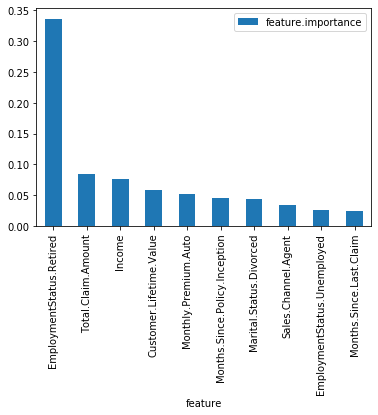

In [19]:
featsortedtop10 = featsorted.head(10)

featsortedtop10.plot(kind='bar', x='feature')

According to the random forest model, retired employees tend to engage with our marketing efforts the most.  Not a suprise, since our dataset is about the marketing for an insurance company.

In [21]:
# Model Evaluation
in_sample = rf_model.predict(x_train)
out_sample = rf_model.predict(x_test)

print('In-Sample Accuracy: %0.4f' % accuracy_score(y_train, in_sample))
print('Out-of-Sample Accuracy: %0.4f' % accuracy_score(y_test, out_sample))

In-Sample Accuracy: 0.8746
Out-of-Sample Accuracy: 0.8814


Accuracy is the number of correct predictions divided by total number of predictions.

In [22]:
print('In-Sample Precision: %0.4f' % precision_score(y_train, in_sample))
print('Out-of-Sample Precision: %0.4f' % precision_score(y_test, out_sample))

In-Sample Precision: 0.9574
Out-of-Sample Precision: 0.8714


Precision is the number of true positives divided by the number of true positives and false positives. You want precision, when you want to know how much the prediction was right.  For example, how many ACTUALLY customers engaged with X campaign than those who were predicted to and did not.

In [23]:
print('In-Sample Recall: %0.4f' % recall_score(y_train, in_sample))
print('Out-of-Sample Recall: %0.4f' % recall_score(y_test, out_sample))

In-Sample Recall: 0.1450
Out-of-Sample Recall: 0.1618


Recall is the number of true positives divided by the number of true positives and false negatives.  In other words, how many the model correctly predicted that customers engaged with X campaign against those that actually did.

When I was learning the difference of precision and recall, it confused me for a bit.  What helped me was looking at the differences of one being good and the other bad [3].  For example, a high precision with a low recall can lead to spotting your target output, but leaving out a few more target output opporunities.  On the other hand, a high recall with a low precision can lead to spotting all target outputs, but predicting target outputs that really aren't.

In [22]:
# ROC and AUC curves
in_sample = rf_model.predict_proba(x_train)[:,1]
out_sample = rf_model.predict_proba(x_test)[:,1]
in_sample_fpr, in_sample_tpr, in_sample_thresholds = roc_curve(y_train, in_sample)
out_sample_fpr, out_sample_tpr, out_sample_thresholds = roc_curve(y_test, out_sample)
in_sample_roc_auc = auc(in_sample_fpr, in_sample_tpr)
out_sample_roc_auc = auc(out_sample_fpr, out_sample_tpr)

print('In-Sample AUC: %0.4f' % in_sample_roc_auc)
print('Out-Sample AUC: %0.4f' % out_sample_roc_auc)

In-Sample AUC: 0.8824
Out-Sample AUC: 0.8623


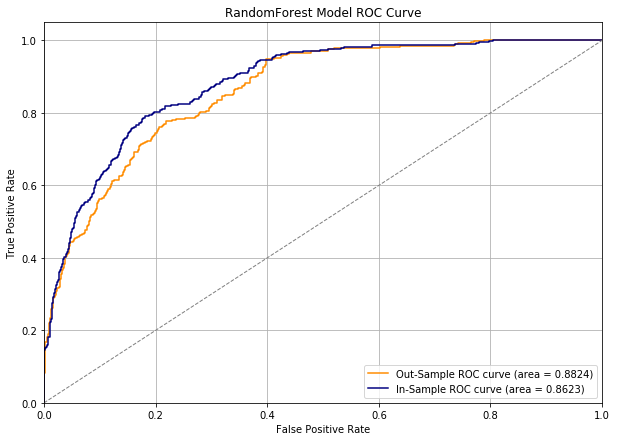

In [23]:
plt.figure(figsize=(10,7))

plt.plot(
    out_sample_fpr, out_sample_tpr, color='darkorange', label='Out-Sample ROC curve (area = %0.4f)' % in_sample_roc_auc
)
plt.plot(
    in_sample_fpr, in_sample_tpr, color='navy', label='In-Sample ROC curve (area = %0.4f)' % out_sample_roc_auc
)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest Model ROC Curve')
plt.legend(loc="lower right")

plt.show()

The ROC curve show the rate of true postives and false psotives, you want the curve to reach the top left the fastest for best model performance.  Our in sample and out of sample curves are alright.  If the gap between the two gets larger, then it is a sign of of the model overfitting to the training data and not finding the general pattern of marketing engagement [4].

# References

[1] A. McEachern, What is Customer Engagement, and Why is it Important? (2019) https://blog.smile.io/what-is-customer-engagement-and-why-is-it-important

[2] IBM Watson, Marketing Customer Value Data (n.d.)
https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data/downloads/ibm-watson-marketing-customer-value-data.zip/1

[3] B. Mikulski, Precision vs. recall - explaination (n.d.) https://www.mikulskibartosz.name/precision-vs-recall-explanation/
    
[4] Y. Hwang, Hands-On Data Science for Marketing (2019), Packt Publishing